In [1]:
import requests
import pytz
import datetime
import numpy as np
import re
import editdistance
import pandas as pd
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from IPython.display import Image
from scipy.misc import imread
import matplotlib.image as mpimg
import requests
import math
import os
import io
from nltk.tokenize import sent_tokenize
import warnings

warnings.filterwarnings("ignore")

%pylab
%matplotlib inline

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


# **Анализ закрытия метро СПб за 2017 год**

Канал **@spbmetro** в Телеграме появился 20-10-2016 (http://www.metro.spb.ru/news/item/id/1041):

> Приветствуем всех. Будем публиковать здесь новости метро, оперативную информацию по закрытиям. В наши времена, когда каждый норовит забыть пакет на скамейке, это весьма актуально.

В июле 2017, по данным "Медиалогии", он вошел в ТОП-5 самых читаемых российских каналов страны.


**Попробую выяснить следующие вопросы (ну и предположения до анализа сформулирую):**

* Как часто закрывались в прошлом году какие станции? (quess: центральные и самые конечные чаще всего)
* на сколько минут какая? (quess: от центра по нарастающей, до 1.5 часов)
* сколько между закрытием и постом в телеграме (quess: 5-10)
* максимальное количество закрытых за день? (quess: все или 12)
* сколько раз встречается слово "падение", "футбол", "хоккей", "неисправность"

## Mining

Клиент для Телеграма, который позволяет выгружать историю:

In [4]:
from telethon import TelegramClient
# https://github.com/LonamiWebs/Telethon

# These example values won't work. You must get your own api_id and
# api_hash from https://my.telegram.org, under API Development.
api_id = 107415
api_hash = '30f9d912ccda513f82700fd84413e5'
phone = '+79215228367'

client = TelegramClient('session_name', api_id, api_hash)
client.connect()

# If you already have a previous 'session_name.session' file, skip this.
client.sign_in(phone=phone)
me = client.sign_in(code=42541)  # Put whatever code you received here.

In [6]:
total, orig_messages, senders = client.get_message_history('@spbmetro', limit=None)
len(orig_messages)

1058

In [7]:
user_timezone = pytz.timezone('Europe/Moscow')
for i in range(5, 20):
    msg = orig_messages[-i]
    print(pytz.utc.localize(msg.date).astimezone(user_timezone).strftime("%Y-%m-%d %H:%M:%S") + ' ' + msg.message)

2016-10-20 15:23:53 15.25 у входа на Ст. Волковская обнаружен без надзорный предмет. По распоряжению Полиции место огорожено. Станция работает. Не закрыта пока.
2016-10-20 15:44:02 Ст. Волковская закрывалась для осмотра с 15.30 открылась в15.36. Опасных предметов не обнаружено.
2016-10-21 17:20:22 17.18 на платформе Ст. Технологический институт 1 обнаружен безнадзорный предмет (сумка). Станция закрыта, поезда следуют без остановки. Переход тоже закрыт. Ст. Техн институт 2 работает.
2016-10-21 17:55:53 В 17.50 станция Технологический институт 1 открыта. В сумке были личные вещи.
2016-10-22 16:13:01 В 16-02 закрыта ст. Удельная для проверки безнадзорного чемодана на платформе.
2016-10-22 17:23:56 Пустой чемодан - футляр удален. Ст. Удельная открыта в 17-09
2016-10-23 11:39:40 Ст. Старая деревня безнадзорная сумка в вестибюле. 11-35 станция закрыта на вход и выход.
2016-10-23 12:14:22 Станция Старая Дер. открыта в 12-10. Взрывоопасных предметов не обнаружено.
2016-10-24 10:20:04 10-21ч ст

За 2017 год:

In [8]:
dates = np.array([l.date.date() for l in orig_messages])
y2017 = np.where((dates >= datetime.date(2017, 1, 1)) & (dates < datetime.date(2018, 1, 1)))
messages = orig_messages[y2017[0][0] : y2017[0][-1]]
print(len(messages))

966


In [9]:
corpora = [msg.message for msg in messages]
dates = [pytz.utc.localize(msg.date).astimezone(user_timezone) for msg in messages]

In [10]:
#read metro stations list
stations = []
f = open('stations.txt', 'r')
for line in f.readlines():
    stations.append(line.replace('\n', ''))
print(len(stations))

67


In [11]:
print(stations)

['Автово', 'Адмиралтейская', 'Академическая', 'Балтийская', 'Бухарестская', 'Василеостровская', 'Владимирская', 'Волковская', 'Выборгская', 'Горьковская', 'Гостиный двор', 'Гражданский проспект', 'Девяткино', 'Достоевская', 'Елизаровская', 'Звёздная', 'Звенигородская', 'Кировский завод', 'Комендантский проспект', 'Крестовский остров', 'Купчино', 'Ладожская', 'Ленинский проспект', 'Лесная', 'Лиговский проспект', 'Ломоносовская', 'Маяковская', 'Международная', 'Московская', 'Московские ворота', 'Нарвская', 'Невский проспект', 'Новочеркасская', 'Обводный канал', 'Обухово', 'Озерки', 'Парк Победы', 'Парнас', 'Петроградская', 'Пионерская', 'Площадь Александра Невского 1', 'Площадь Александра Невского 2', 'Площадь Восстания', 'Площадь Ленина', 'Площадь Мужества', 'Политехническая', 'Приморская', 'Пролетарская', 'Проспект Большевиков', 'Проспект Ветеранов', 'Проспект Просвещения', 'Пушкинская', 'Рыбацкое', 'Садовая', 'Сенная площадь', 'Спасская', 'Спортивная', 'Старая Деревня', 'Технологическ

Искать будем по сигнатурам:

In [12]:
signatures = [' '.join([w[:6] for w in l.lower().split(' ') ]) for l in stations]
len(set(signatures))

67

In [13]:
print(signatures)

['автово', 'адмира', 'академ', 'балтий', 'бухаре', 'василе', 'владим', 'волков', 'выборг', 'горько', 'гостин двор', 'гражда проспе', 'девятк', 'достое', 'елизар', 'звёздн', 'звениг', 'кировс завод', 'коменд проспе', 'кресто остров', 'купчин', 'ладожс', 'ленинс проспе', 'лесная', 'лиговс проспе', 'ломоно', 'маяков', 'междун', 'москов', 'москов ворота', 'нарвск', 'невски проспе', 'новоче', 'обводн канал', 'обухов', 'озерки', 'парк победы', 'парнас', 'петрог', 'пионер', 'площад алекса невско 1', 'площад алекса невско 2', 'площад восста', 'площад ленина', 'площад мужест', 'полите', 'примор', 'пролет', 'проспе больше', 'проспе ветера', 'проспе просве', 'пушкин', 'рыбацк', 'садова', 'сенная площад', 'спасск', 'спорти', 'старая деревн', 'технол инстит 1', 'технол инстит 2', 'удельн', 'улица дыбенк', 'фрунзе', 'чёрная речка', 'черныш', 'чкалов', 'электр']


In [14]:
another_signatures = {}
for station in stations:
    if 'проспект' in station.lower():
        sign = ' '.join([w[:6] for w in station.lower().split(' ')])
        another_signatures[sign] = ' '.join([w[:6] for w in station.lower().replace('проспект', 'пр.').split(' ')])
    if 'площадь' in station.lower():
        sign = ' '.join([w[:6] for w in station.lower().split(' ')])
        another_signatures[sign] = ' '.join([w[:6] for w in station.lower().replace('площадь', 'пл.').split(' ')])
    if 'ё' in station.lower():
        sign = ' '.join([w[:6] for w in station.lower().split(' ')])
        another_signatures[sign] = ' '.join([w[:6] for w in station.lower().replace('ё', 'е').split(' ')])
    if 'улица ' in station.lower():
        sign = ' '.join([w[:6] for w in station.lower().split(' ')])
        another_signatures[sign] = ' '.join([w[:6] for w in station.lower().replace('улица ', '').split(' ')])
    if 'институт' in station.lower():
        sign = ' '.join([w[:6] for w in station.lower().split(' ')])
        another_signatures[sign] = ' '.join([w[:6] for w in station.lower().replace('институт', 'ин т').split(' ')])
another_signatures

{'гражда проспе': 'гражда пр.',
 'звёздн': 'звездн',
 'коменд проспе': 'коменд пр.',
 'ленинс проспе': 'ленинс пр.',
 'лиговс проспе': 'лиговс пр.',
 'невски проспе': 'невски пр.',
 'площад алекса невско 1': 'пл. алекса невско 1',
 'площад алекса невско 2': 'пл. алекса невско 2',
 'площад восста': 'пл. восста',
 'площад ленина': 'пл. ленина',
 'площад мужест': 'пл. мужест',
 'проспе больше': 'пр. больше',
 'проспе ветера': 'пр. ветера',
 'проспе просве': 'пр. просве',
 'сенная площад': 'сенная пл.',
 'технол инстит 1': 'технол ин т 1',
 'технол инстит 2': 'технол ин т 2',
 'улица дыбенк': 'дыбенк',
 'чёрная речка': 'черная речка'}

In [15]:
another_signatures2 = {}
for station in stations:
    if 'проспект' in station.lower():
        sign = ' '.join([w[:6] for w in station.lower().split(' ')])
        another_signatures2[sign] = ' '.join([w[:6] for w in station.lower().replace('проспект', 'пр').split(' ')])
    if 'площадь' in station.lower():
        sign = ' '.join([w[:6] for w in station.lower().split(' ')])
        another_signatures2[sign] = ' '.join([w[:6] for w in station.lower().replace('площадь', 'пл').split(' ')])
    if ' 1' in station.lower():
        sign = ' '.join([w[:6] for w in station.lower().split(' ')])
        another_signatures2[sign] = ' '.join([w[:6] for w in station.lower().replace(' 1', '').split(' ')])
    if ' 2' in station.lower():
        sign = ' '.join([w[:6] for w in station.lower().split(' ')])
        another_signatures2[sign] = ' '.join([w[:6] for w in station.lower().replace(' 2', '').split(' ')])
another_signatures2

{'гражда проспе': 'гражда пр',
 'коменд проспе': 'коменд пр',
 'ленинс проспе': 'ленинс пр',
 'лиговс проспе': 'лиговс пр',
 'невски проспе': 'невски пр',
 'площад алекса невско 1': 'площад алекса невско',
 'площад алекса невско 2': 'площад алекса невско',
 'площад восста': 'пл восста',
 'площад ленина': 'пл ленина',
 'площад мужест': 'пл мужест',
 'проспе больше': 'пр больше',
 'проспе ветера': 'пр ветера',
 'проспе просве': 'пр просве',
 'сенная площад': 'сенная пл',
 'технол инстит 1': 'технол инстит',
 'технол инстит 2': 'технол инстит'}

In [16]:
text = 'В 13-51 движение по Линии 4 восстановлено. Пассажир извлечён из-под состава и передан врачам Скорой помощи'
sentences = sent_tokenize(text)
print(sentences)

['В 13-51 движение по Линии 4 восстановлено.', 'Пассажир извлечён из-под состава и передан врачам Скорой помощи']


Извлекаем данные:

In [17]:
extracted_data = []

for i in range(0, len(messages)):
    msg = messages[i]
    
    for sent in sent_tokenize(msg.message.replace('Пл.', 'пл ').replace('Пр.', 'пр ').replace('Ул.', 'ул ').
                              replace('пл.', 'пл ').replace('пр.', 'пр ').replace('ул.', 'ул ').replace('ст.', 'ст ')):

        
        text = sent
        
        if len(text) == 0:
            continue

        actual_date = pytz.utc.localize(msg.date).astimezone(user_timezone).strftime("%Y-%m-%d %H:%M:%S")
        
        ### search stations
        splitted = text.lower().replace('-', ' ').replace('1,2', '1').replace('пл.', 'пл ').replace('пр.', 'пр ').replace('ул.', 'ул ').replace('ст.', 'ст ').replace('.', '. ').split(' ')
        short_splitted = ' '.join([l[:6] for l in splitted])
        short_splitted = ' '.join(short_splitted.split())
        found = []
        for ind, signature in enumerate(signatures):
            if signature in short_splitted:
                found.append(stations[ind])
            if signature in another_signatures.keys():
                if another_signatures[signature] in short_splitted:
                    found.append(stations[ind])
            if signature in another_signatures2.keys():
                if another_signatures2[signature] in short_splitted:
                    found.append(stations[ind])
        if len(found) == 0:
            for station in stations:
                for word in station.lower().split(' '):
                    if word not in ['проспект', 'площадь', '1', '2',  'канал']:
                        if word in ' '.join(splitted):
                            found.append(station)
        if found:
            ### time
            regexp = re.compile("\d?\d[.\-:]\d\d")
            msgtime = re.findall(regexp, text)
            
            if len(msgtime) > 2:
                continue 
            
            data = [text, i, actual_date]
            data.append(set(found))
            
            
            if msgtime:
                data.append(msgtime)
            else:
                data.append([])

            ### status
            status = 'UNKNOWN'
            if 'откры' in text or 'не закры' in text or ('обыч' in text and 'режим' in text):
                status = 'OPEN'
            elif 'закры' in text:
                status = 'CLOSE'
            data.append(status)          
    extracted_data.append(data)

In [18]:
len(extracted_data)

966

In [19]:
extracted_data[750]

['17-22 ст  Парнас закрыта на вход.',
 750,
 '2017-06-07 17:23:29',
 {'Парнас'},
 ['17-22'],
 'CLOSE']

Сложные случаи:

In [20]:
complex_messages = []
easy = 0
several_stations = 0
unkn = 0
for ind, entity in enumerate(extracted_data):
#     print(entity)
    text, i, actt, sts, tts, stat = entity
    
    if len(sts) == len(tts) == 1 and stat is not 'UNKNOWN':
        easy += 1
    elif len(sts) > 1 and len(tts) == 1 and stat is not 'UNKNOWN':
        several_stations += 1
    elif stat is 'UNKNOWN':
        unkn += 1
    else:
        pass
    
#     if len(sts) == len(tts) == 1:
    if len(tts) <= 1:
        continue
    else:
        complex_messages.append(entity)
        
len(complex_messages), easy, several_stations, unkn, easy+several_stations+unkn

(1, 681, 131, 82, 894)

In [21]:
complex_messages

[['Волковская открыта в 13-59 мин, ст  пл  Восстания1,2 открыта в 13-57 мин.',
  199,
  '2017-12-07 14:06:11',
  {'Волковская', 'Площадь Восстания'},
  ['13-59', '13-57'],
  'OPEN']]

In [22]:
def show_station_messages(station):
    station_messages = []
    station_ids = []
    for ind, entity in enumerate(extracted_data):
        text, i, actt, sts, tts, stat = entity

        if station in sts and stat is not 'UNKNOWN' and i not in station_ids:
            station_messages.append([tts, stat, actt, text, i])
            station_ids.append(i)

    status_sum = 0
    for i in range(len(station_messages))[::-1]:
        msg = station_messages[i]
        if msg[1] == 'CLOSE':
            status_sum -= 1
        elif msg[1] == 'OPEN':
            status_sum += 1
    
    actual_date = datetime.datetime.strptime(station_messages[-1][2], "%Y-%m-%d %H:%M:%S")
    for i in range(len(station_messages))[::-1]:
        date = datetime.datetime.strptime(station_messages[i][2], "%Y-%m-%d %H:%M:%S")
#         print(actual_date.date(), date.date(), actual_date.date() == date.date())
        if actual_date.date() == date.date():
            pass
        else:
#             print(actual_date.date(), date - datetime.timedelta(hours=1))
            if actual_date.date() == (date - datetime.timedelta(hours=1)).date():
                pass
            else:
                print('-'*10)
            actual_date = date
        print(station_messages[i])

show_station_messages('Чернышевская')

[['08-02'], 'CLOSE', '2017-01-27 08:13:19', 'В 08-02  станция Чернышевская закрыта по указанию Полиции, по 1 пути на платформе бесхозный предмет (Коробка), поезда проследуют станцию без остановки.', 958]
[['08-34'], 'OPEN', '2017-01-27 08:36:34', '08-34 станция Чернышевская открыта.', 957]
----------
[['23-50'], 'OPEN', '2017-04-03 23:55:00', 'Чернышевская  открыта в 23-50', 892]
----------
[['14-22'], 'CLOSE', '2017-06-09 14:24:48', '14-22 ст  Чернышевская закрыта на вход и выход.', 744]
[['14-53'], 'OPEN', '2017-06-09 14:56:35', 'В 14-53 ст  Чернышевская  открыта.', 743]
----------
[['14-55'], 'CLOSE', '2017-10-11 14:58:06', 'В 14-55 ст  Чернышевская  закрыта на проверку.', 384]
[['15-05'], 'OPEN', '2017-10-11 15:04:14', 'В 15-05 ст  Чернышевская открыта.', 383]
----------
[['21-46'], 'CLOSE', '2017-11-20 21:59:09', 'В 21-46 ст  Чернышевская закрыта, поезда следуют на проезд.', 271]
[['22-31'], 'OPEN', '2017-11-20 22:39:11', 'В 22-31 ст  Чернышевская открыта.', 270]
----------
[['23-

In [79]:
show_station_messages('Ломоносовская')

[['15-48'], 'OPEN', '2017-01-24 15:52:13', 'Ломоносовская открыта на вход в 15-48, посторонний предмет удалён.', 959]
----------
[['22-04'], 'CLOSE', '2017-12-30 22:15:38', 'В 22-04 ст  Ломоносовская закрыта из-за бесхозного предмета', 10]
[['23-10'], 'OPEN', '2017-12-30 23:12:03', 'В 23-10 ст  Ломоносовская открыта.', 9]


In [77]:
corpora[960:965]

['Ст. Ломоносовская попадание постороннего предмета в эскл. №1 (спуск.) Станция в 15ч 25 мин закрыта. Эскл. №3 в ремонте.',
 'В 21ч 42 мин переход Гостиный двор- Невский пр. открыт. Взрывоопасных предметов не обнаружено.',
 'Переход Невский пр- Гостиный двор закрыт в 21ч.05 мин  в связи с бесхозным предметом (коробка.) Станция Невский пр и Гостиный двор работают в нормальном режиме.',
 'Станция Горьковская открыта в 20-48. Взрывоопасных предметов не обнаружено.',
 'ст. Горьковская на платформе бесхозный предмет (спортивная сумка). Станция в 20ч10 мин закрыта. Поезда проследуют станцию без остановки.']

Проблемы с очередностью открыто-закрыто:

In [87]:
for station in stations:
    station_messages = []
    station_ids = []
    for ind, entity in enumerate(extracted_data):
        text, i, actt, sts, tts, stat = entity

        if station in sts and stat is not 'UNKNOWN' and i not in station_ids:
            station_messages.append([tts, stat, actt, text, i])
            station_ids.append(i)

    status_sum = ''            
    actual_date = datetime.datetime.strptime(station_messages[-1][2], "%Y-%m-%d %H:%M:%S")
    status = ''
    
    for i in range(len(station_messages))[::-1]:
        date = datetime.datetime.strptime(station_messages[i][2], "%Y-%m-%d %H:%M:%S")
        
        if actual_date.date() == date.date() or actual_date.date() == (date - datetime.timedelta(hours=1)).date():
            msg = station_messages[i]
            if msg[1] == 'CLOSE':
                status_sum = status_sum + 'C'
            elif msg[1] == 'OPEN':
                if status_sum:
                    if status_sum[-1] == 'C':
                        status_sum = status_sum[:-1]
                    else:
                        status_sum = status_sum + 'O'
                else:
                    status_sum = status_sum + 'O'
        else:            
            actual_date = date
            if status_sum:
                status = status + '|' + status_sum
            status_sum = 'C' if station_messages[i][1] == 'CLOSE' else 'O'
    
    print('{:40} sum={:40} len={:2}'.format(station, status, len(station_messages)))

Автово                                   sum=                                         len=28
Адмиралтейская                           sum=|O                                       len=25
Академическая                            sum=                                         len=14
Балтийская                               sum=                                         len= 6
Бухарестская                             sum=|O                                       len= 7
Василеостровская                         sum=                                         len=16
Владимирская                             sum=|C|O|C|O|O|C|OO|C                        len=37
Волковская                               sum=                                         len= 2
Выборгская                               sum=|C                                       len= 5
Горьковская                              sum=|O                                       len=11
Гостиный двор                            sum=|O|C|O|O|C|C|C           

Извлечение времени из строчек:

In [156]:
for ind, entity in enumerate(extracted_data):
    text, i, actt, sts, tts, stat = entity
    actual_date = datetime.datetime.strptime(actt, "%Y-%m-%d %H:%M:%S")
    hour, minute = actual_date.hour, actual_date.minute
    if tts:
        try:
            if '.' in tts[0]:
                hour, minute = tts[0].split('.')
            elif '-' in tts[0]:
                hour, minute = tts[0].split('-')
            elif ':' in tts[0]:
                hour, minute = tts[0].split(':')
        except Exception:
            print(tts)
    text_date = actual_date.replace(hour=int(hour), minute=int(minute))
#     print(actual_date, text_date, tts, hour, minute)

Работа с картой. Metro connections можно найти например тут: https://github.com/nextgis/metro4all/blob/master/data/spb/graph.csv

In [104]:
mdata = pd.read_csv('graph.csv', delimiter=';', encoding = "cp1251")
mdata.head()

,id_from,id_to,name_from,name_to,cost
0,3,4,Проспект Ветеранов,Ленинский проспект,133
1,4,5,Ленинский проспект,Автово,150
2,5,6,Автово,Кировский завод,133
3,6,7,Кировский завод,Нарвская,188
4,7,8,Нарвская,Балтийская,144


In [ ]:
#Get station longitude and latitude from it name with Yandex Geocode PI  
payload = {'geocode': 'метро Маяковская', 'll': '30.3159,59.93914', 'spn' : '0.552069,0.400552'}

lons, lats = [], []
for station in stations:
    payload['geocode'] = 'метро '+ station
    response = requests.get('https://geocode-maps.yandex.ru/1.x/',
                         params=payload)
    y=BeautifulSoup(response.text)
    results = y.findAll("pos")
    if results:
        lon, lat = str(results[0])[5:-6].split(' ')
        lons.append(float(lon))
        lats.append(float(lat))

In [94]:
np.save('lons.npy', lons)
np.save('lats.npy', lats)

In [110]:
lons = np.load('lons.npy')
lats = np.load('lats.npy')

In [118]:
station_id = {}
for ind, station in enumerate(stations):
    station_id[station.lower()] = ind

# add missing connections
connections = list(zip(mdata.name_from.values, mdata.name_to.values))
connections.append(('Елизаровская',  'Площадь Александра Невского 1'))
connections.append(('Елизаровская', 'Ломоносовская'))

connections_ind = []
for connection in connections:
    connections_ind.append([station_id[connection[0].lower()], station_id[connection[1].lower()]])
    
    
id_to_id = {}
for name, id_ in list(zip(mdata.name_from.values, mdata.id_from.values)):
    for ind, station in enumerate(stations):
        if station == name:
            id_to_id[id_] = ind
            
inter = np.genfromtxt('inter.csv', delimiter=';', skip_header=True)
inters = []
for interconn in zip(inter[:, 0], inter[:, 1]):
    st1, st2 = interconn
    inters.append([id_to_id[st1], id_to_id[st2]])
    
#read metro lines list
lines = []
line = []
with io.open('lines.txt', encoding='utf-8') as file_:
    for station in file_:
        if station == '\n':
            lines.append(line)
            line = []
        else:
            line.append(station.lower().replace('\n', ''))
lines.append(line)
print(len(lines))
lines_d = {l[0]:l[1] for l in zip(range(len(lines)), ['r', 'g', 'orange', 'm'])}

4


Карта с кривыми подписями:

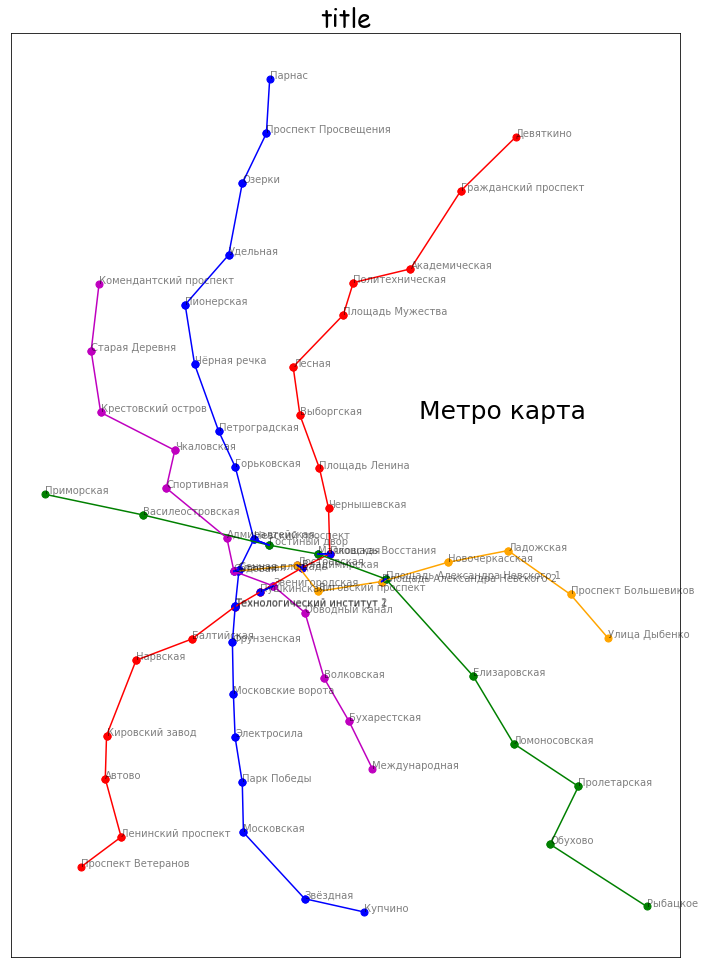

In [119]:
plt.figure(figsize=[12,17])
# plt.scatter(lons, lats, 100, 'r')

for connection in connections_ind:
    st1, st2 = connection
    st1_n, st2_n = stations[st1], stations[st2]
    color = 'b'
    for ind, line in enumerate(lines):
        if st1_n.lower() in line and st2_n.lower() in line:
            color = lines_d[ind]
    plt.plot([lons[st1], lons[st2]], [lats[st1], lats[st2]], '-', color=color)
    plt.scatter([lons[st1], lons[st2]], [lats[st1], lats[st2]], 50, color=color)
    
for inter in inters:
    st1, st2 = inter
    plt.plot([lons[st1], lons[st2]], [lats[st1], lats[st2]], '-', color='b')
    
for ind, station in enumerate(stations):
    plt.text(lons[ind], lats[ind], station, fontsize=10, alpha=0.5)
    
csfont = {'fontname':'Comic Sans MS', 'fontsize' : 25}
hfont = {'fontname':'Helvetica', 'fontsize' : 25}

plt.title('title',**csfont)
plt.text(30.40, 59.97, 'Метро карта', **hfont)
plt.xticks([])
plt.yticks([])
plt.show()

## Анализ, результаты

Повторю вопросы:

- Как часто закрывались в прошлом году какие станции? (quess: центральные и самые конечные чаще всего)
- на сколько минут какая? (quess: от центра по нарастающей, до 1.5 часов)
- сколько между закрытием и постом в телеграме (quess: 5-10)
- максимальное количество закрытых за день? (quess: все или 12)
- сколько раз встречается слово "падение", "футбол", "хоккей", "неисправность"

### Просмотры

Популярность канала:

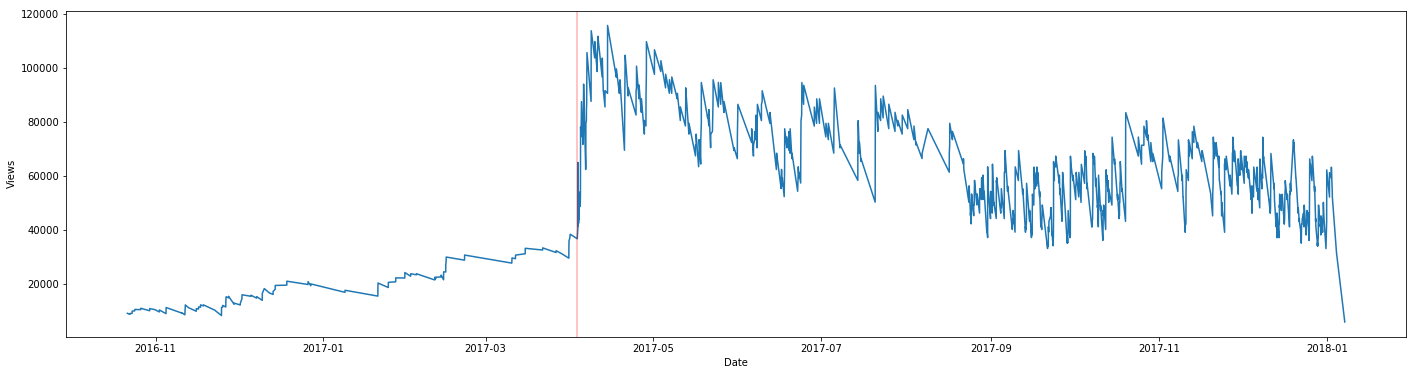

In [103]:
fig = plt.figure(figsize=[24, 6])
plt.plot([pytz.utc.localize(l.date).astimezone(user_timezone) for l in orig_messages[:1050]], 
         [l.views for l in orig_messages[:1050]],'-')
plt.axvline(x = datetime.date(2017, 4, 3), color = 'r', alpha=0.3)
plt.ylabel('Views')
plt.xlabel('Date')

### Задержка между закрытием и сообщением

сколько между закрытием/событием и постом в телеграме (quess: 5-10)

In [199]:
post_delay = []
for ind, entity in enumerate(extracted_data):
    text, i, actt, sts, tts, stat = entity
    actual_date = datetime.datetime.strptime(actt, "%Y-%m-%d %H:%M:%S")
#     hour, minute = actual_date.hour, actual_date.minute
    hour, minute = None, None
    if tts:
        try:
            if '.' in tts[0]:
                hour, minute = tts[0].split('.')
            elif '-' in tts[0]:
                hour, minute = tts[0].split('-')
            elif ':' in tts[0]:
                hour, minute = tts[0].split(':')
        except Exception:
            print(tts)
    if hour is not None and minute is not None:
        text_date = actual_date.replace(hour=int(hour), minute=int(minute), second=actual_date.second)
        post_delay.append((actual_date - text_date).total_seconds()/60.)
        
len(post_delay)

824

(0, 128.09999999999999)

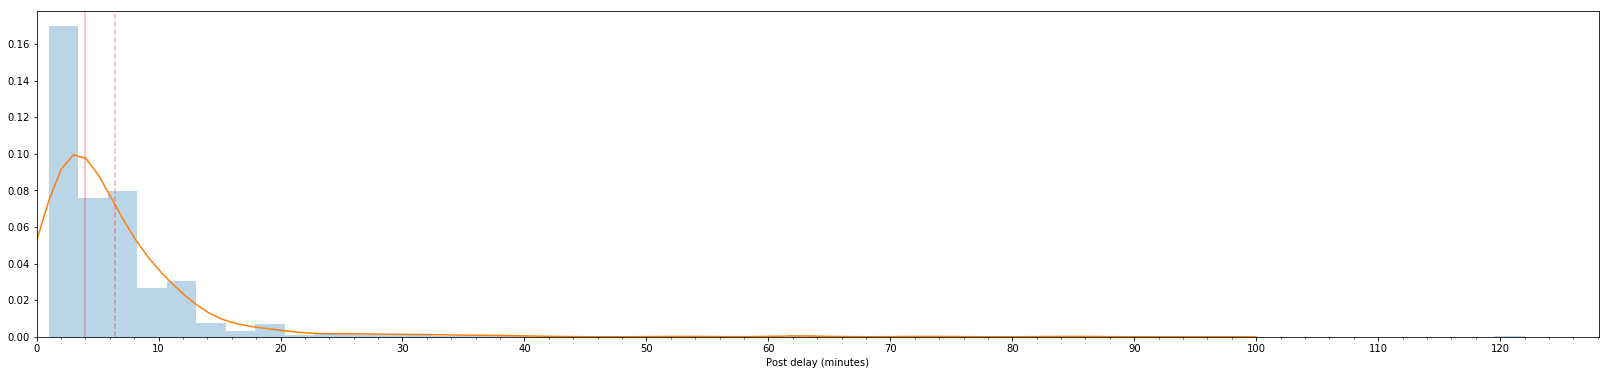

In [214]:
from scipy import stats
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

minorLocator = MultipleLocator(2)
majorLocator = MultipleLocator(10)

post_delay = np.array(post_delay)
post_delay = post_delay[post_delay > 0]

kde = stats.gaussian_kde(post_delay)
xx = np.linspace(0, 100, 100)

fig, ax = plt.subplots(figsize=(28,6))
ax.hist(post_delay, normed=True, bins=50, alpha=0.3)
ax.plot(xx, kde(xx))
ax.xaxis.set_minor_locator(minorLocator)
ax.xaxis.set_major_locator(majorLocator)
plt.xlabel('Post delay (minutes)')
plt.axvline(x=np.median(post_delay), ls='-', color='r', alpha=0.3)
plt.axvline(x=np.mean(post_delay), ls='--', color='r', alpha=0.3)
plt.xlim(0)

Неплохой результат, меньше предполагаемого.

### Какие закрывались чаще всего

Как часто закрывались в прошлом году какие станции? (quess: центральные и самые конечные чаще всего)

In [218]:
station_mentions = {}
for ind, entity in enumerate(extracted_data):
    text, i, actt, sts, tts, stat = entity
    for st in sts:
        if st in station_mentions.keys():
            station_mentions[st] += 1
        else:
            station_mentions[st] = 1

In [260]:
for k, v in sorted(station_mentions.items(), key=lambda l: (l[1],l[0]), reverse=True): print(k, v)

Площадь Восстания 66
Крестовский остров 52
Маяковская 48
Невский проспект 43
Достоевская 42
Владимирская 42
Спасская 35
Ладожская 35
Старая Деревня 33
Гостиный двор 32
Автово 30
Сенная площадь 27
Садовая 27
Проспект Большевиков 27
Площадь Ленина 26
Пушкинская 25
Проспект Просвещения 25
Адмиралтейская 25
Пионерская 24
Технологический институт 1 22
Технологический институт 2 21
Приморская 20
Петроградская 20
Звенигородская 20
Гражданский проспект 20
Чернышевская 18
Удельная 18
Чёрная речка 17
Василеостровская 17
Академическая 16
Горьковская 15
Московская 14
Лиговский проспект 14
Нарвская 13
Комендантский проспект 13
Звёздная 13
Улица Дыбенко 12
Спортивная 12
Озерки 12
Проспект Ветеранов 11
Новочеркасская 11
Девяткино 11
Электросила 10
Парнас 10
Парк Победы 10
Обводный канал 10
Купчино 10
Рыбацкое 9
Ленинский проспект 9
Фрунзенская 8
Бухарестская 8
Площадь Мужества 7
Площадь Александра Невского 2 7
Площадь Александра Невского 1 7
Международная 7
Пролетарская 6
Ломоносовская 6
Елизаровская

Тут надо делить на два, но для карты это не важно.

Карта:

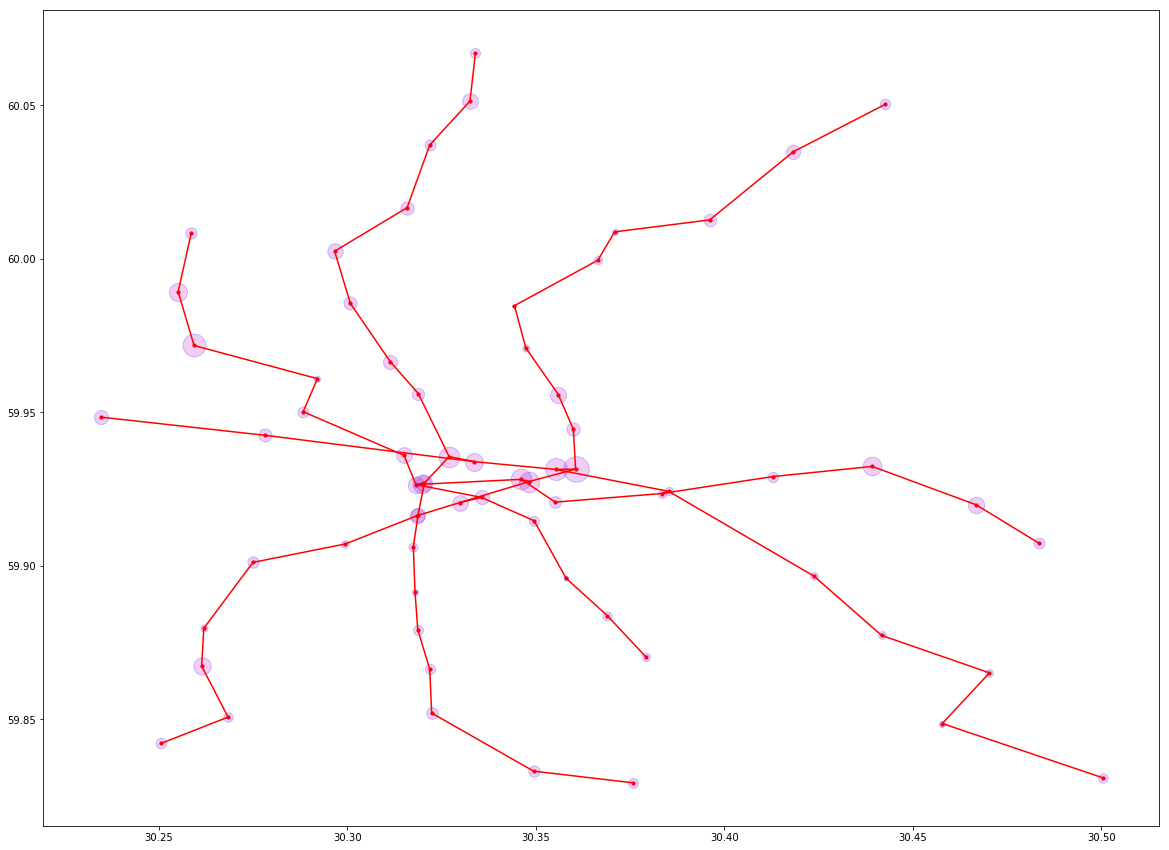

In [223]:
plt.figure(figsize=[20,15])
plt.scatter(lons, lats, 10, 'r')
for connection in connections_ind:
    st1, st2 = connection
    plt.plot([lons[st1], lons[st2]], [lats[st1], lats[st2]], '-', color='r')
    
for ind,station in enumerate(stations):
    if station in station_mentions.keys():
        plt.scatter(lons[ind], lats[ind], 10*station_mentions[station], 'm', edgecolor='b', alpha=0.2)

Про крайние я не угадал, а про центр и так понятно.

*На самом деле это скорее упоминания, а не точное число, но связь думаю самая прямая.*

### На сколько закрывались

на сколько минут какая? (quess: от центра по нарастающей, до 1.5 часов)

In [23]:
def get_text_time(actt, tts):
    actual_date = datetime.datetime.strptime(actt, "%Y-%m-%d %H:%M:%S")
    hour, minute = actual_date.hour, actual_date.minute
    if tts:
        try:
            if '.' in tts[0]:
                hour, minute = tts[0].split('.')
            elif '-' in tts[0]:
                hour, minute = tts[0].split('-')
            elif ':' in tts[0]:
                hour, minute = tts[0].split(':')
        except Exception:
            print(tts)
    if hour is not None and minute is not None:
        text_date = actual_date.replace(hour=int(hour), minute=int(minute), second=actual_date.second)
    return actual_date, text_date

closed_time = []
for station in stations:
    station_messages = []
    station_ids = []
    for ind, entity in enumerate(extracted_data):
        text, i, actt, sts, tts, stat = entity

        if station in sts and stat is not 'UNKNOWN' and i not in station_ids:
            station_messages.append([tts, stat, actt, text, i])
            station_ids.append(i)

    status_sum = ''            
    actual_date = datetime.datetime.strptime(station_messages[-1][2], "%Y-%m-%d %H:%M:%S")
    status = ''
    
    for i in range(len(station_messages))[::-1]:
        tts, stat, actt, text, _ = station_messages[i]
        date = datetime.datetime.strptime(station_messages[i][2], "%Y-%m-%d %H:%M:%S")
        
        if actual_date.date() == date.date() or actual_date.date() == (date - datetime.timedelta(hours=1)).date():
            msg = station_messages[i]
            if msg[1] == 'CLOSE':
                status_sum = status_sum + 'C'
            elif msg[1] == 'OPEN':
                if status_sum:
                    if status_sum[-1] == 'C':
                        status_sum = status_sum[:-1]
                        
                        tts1, stat1, actt1, text1, i1 = station_messages[i+1]
                        closed_time.append([station, get_text_time(actt1,tts1)[1], get_text_time(actt,tts)[1]])
#                         if (get_text_time(actt,tts)[1]-get_text_time(actt1,tts1)[1]).total_seconds()/60. > 250:
#                             print(actt,tts,actt1,tts1)
                    else:
                        status_sum = status_sum + 'O'
                else:
                    status_sum = status_sum + 'O'
        else:            
            actual_date = date
            if status_sum:
                status = status + '|' + status_sum
            status_sum = 'C' if station_messages[i][1] == 'CLOSE' else 'O'

In [24]:
len(closed_time)

431

In [25]:
closed_time_s = np.array([(l[2]-l[1]).total_seconds()/60. for l in closed_time])

In [26]:
closed_time_s = sorted(closed_time_s)

(0, 165.80500000000004)

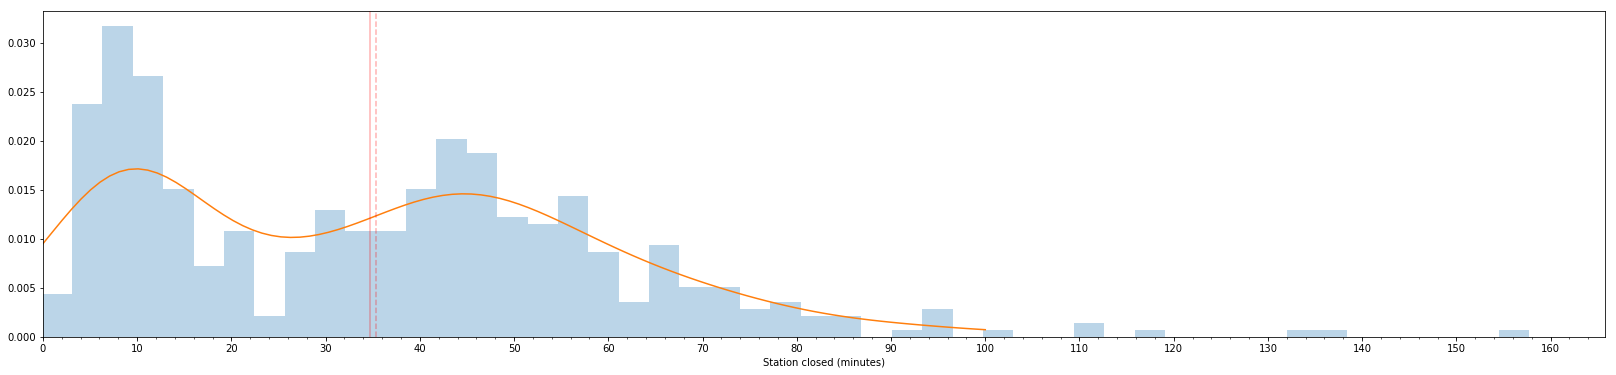

In [27]:
from scipy import stats
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

minorLocator = MultipleLocator(2)
majorLocator = MultipleLocator(10)

kde = stats.gaussian_kde(closed_time_s[:-1])
xx = np.linspace(0, 100, 100)

fig, ax = plt.subplots(figsize=(28,6))
ax.hist(closed_time_s[:-1], normed=True, bins=50, alpha=0.3)
ax.plot(xx, kde(xx))
ax.xaxis.set_minor_locator(minorLocator)
ax.xaxis.set_major_locator(majorLocator)
plt.xlabel('Station closed (minutes)')
plt.axvline(x=np.median(closed_time_s[:-1]), ls='-', color='r', alpha=0.3)
plt.axvline(x=np.mean(closed_time_s[:-1]), ls='--', color='r', alpha=0.3)
plt.xlim(0)

Странно что так много быстро открывшихся станций. Я думаю в этом пункте достаточно большая погрешность.

Но в целом действительно есть много быстро открывшихся - например 26 марта 2017:

> В 16-00 ст. Крестовский остров закрыта, поезда следуют без остановки. В вестибюле бесхозный предмет.

> 16-05 ст. Крестовский остров открыта.

И сходных примеров я видел достаточно - часто это падение на пути.

TODO Интересно конечно было бы посмотреть, как это число меняется со временем. 

### Максимум закрыто за день раз

Сколько максимум было закрыто (раз, т.е. одна станция может считаться больше одного раза) в день?

In [28]:
closed_per_day = {}
for st, ct, ot in closed_time:
    date = ct.date()
    if date in closed_per_day.keys():
        closed_per_day[date] += 1
    else:
        closed_per_day[date] = 1

In [30]:
closed_per_day = sorted(closed_per_day.items())

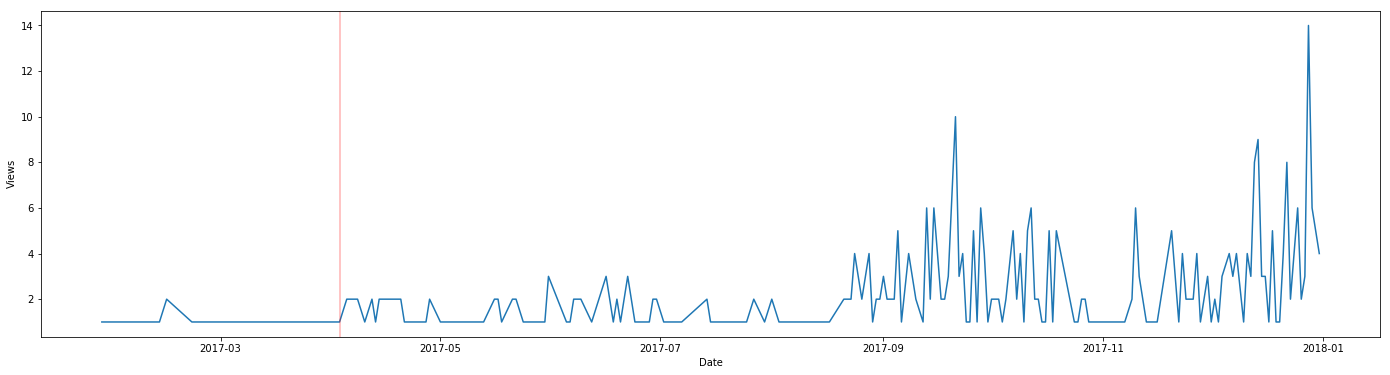

In [39]:
fig = plt.figure(figsize=[24, 6])
plt.plot(list(zip(*closed_per_day))[0], list(zip(*closed_per_day))[1], '-')
plt.axvline(x = datetime.date(2017, 4, 3), color = 'r', alpha=0.3)
plt.ylabel('Views')
plt.xlabel('Date')

Порядок угадан, очень близко. Тут конечно нужны еще прояснения. Плюс кажется, что с общим числом "упоминаний" это не очень согласуется.

### Время закрытия

В какие часы чаще всего закрываются:

In [51]:
sample_date = datetime.datetime.now()
sample_dates = []
for st, ct, ot in closed_time:
    s_date = sample_date.replace(hour=ct.hour, minute=ct.minute, second=ct.second)
    sample_dates.append(s_date)

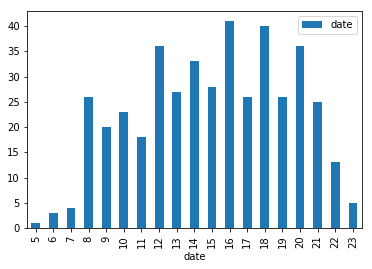

In [74]:
df = pd.DataFrame(data=sample_dates, columns=['date'])
df.groupby(df["date"].dt.hour).count().plot(kind="bar")

Какого-то прям "часа пик" нет.

### Другие причины

сколько раз встречается слово "падение", "футбол", "хоккей", "неисправность"

In [40]:
fulltext = ' '.join(corpora)

In [44]:
for word in ["паден", "футбол", "хоккей", "неисправн"]:
    print(word + ' : ' + str(fulltext.count(word)))

паден : 6
футбол : 9
хоккей : 3
неисправн : 11


In [48]:
from collections import Counter
words = re.findall('\w+', fulltext.lower())
Counter(words).most_common(20)

[('ст', 1004),
 ('в', 951),
 ('на', 539),
 ('открыта', 335),
 ('закрыта', 330),
 ('и', 310),
 ('не', 228),
 ('предметов', 223),
 ('обнаружено', 219),
 ('предмета', 214),
 ('бесхозного', 210),
 ('опасных', 208),
 ('из', 205),
 ('за', 201),
 ('вход', 175),
 ('переход', 130),
 ('бесхозный', 119),
 ('предмет', 105),
 ('20', 103),
 ('выход', 98)]

Тут конечно надо бы нормализацию провести само собой, но кажется что ничего интересного все равно не найти (может tf-idf, но не сильно интересно).

## Appendix

*Подвал заготовок без комментариев*

In [5]:
# TODO: добавить
regexp = re.compile("\d?\dч[ ]?\d\d[ ]?мин")
re.findall(regexp, 'Станция в 20ч10 мин закрыта. Станция в 15ч 25 мин закрыта')

['20ч10 мин', '15ч 25 мин']

In [6]:
# TODO: добавить
regexp = re.compile("закры|откры")
re.findall(regexp, 'В 17-14 ст  Владимирская закрыта, а ст  Достоевская открыта.')

['закры', 'откры']

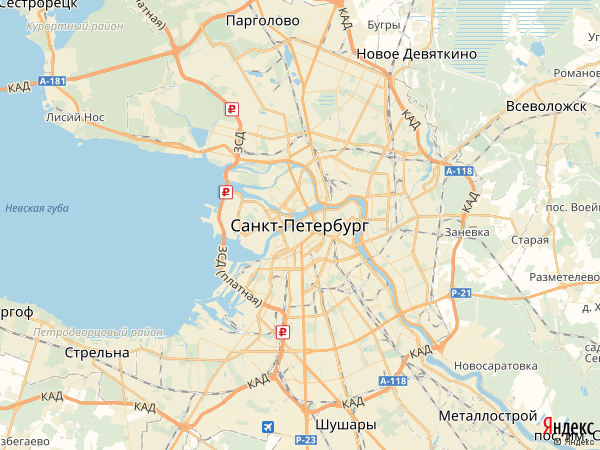

In [226]:
#SPb center
c_lon, c_lat = 30.3159, 59.9391 
#Image radius in degrees
spn = 0.3
spb_map = Image(filename='spb_small.png')
spb_map

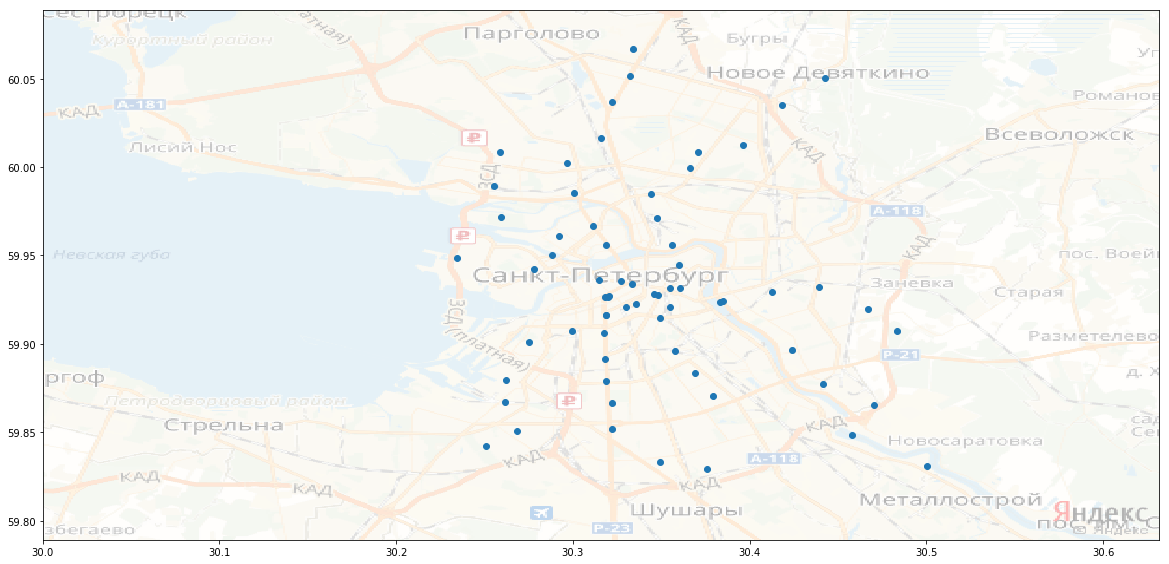

In [253]:
img = mpimg.imread('spb_small.png')
fig = plt.figure(figsize=[20,15])
# plt.scatter([c_lon], [c_lat], color ='red', zorder=1)
plt.scatter(lons, lats, zorder=1)
# plt.imshow(img, zorder=0, extent=[c_lon-spn, c_lon+spn, c_lat-spn, c_lat+spn], alpha=0.3)
Nx = 0.95
Ny = 2.
plt.imshow(img, zorder=0,  extent=[c_lon-spn/Nx, c_lon+spn/Nx, c_lat-spn/Ny, c_lat+spn/Ny], alpha=0.3)
plt.show()

In [302]:
import bokeh
bokeh.io.output_notebook()

Loading BokehJS ...

In [313]:
import pandas as pd
from bokeh.charts import output_file, Chord
from bokeh.io import show
from bokeh.sampledata.les_mis import data
 
# nodes = data['nodes']
# links = data['links']
# groups = [ for l in stations]
nodes = [{'group' : stations.index(l)%4, 'name' : l} for l in stations]
links = [{'source': l[0], 'target': l[1], 'value': 1} for l in connections_ind]
 
nodes_df = pd.DataFrame(nodes)
links_df = pd.DataFrame(links)
 
source_data = links_df.merge(nodes_df, how='left', left_on='source', right_index=True)
source_data = source_data.merge(nodes_df, how='left', left_on='target', right_index=True)
# source_data = source_data[source_data["value"] > 5]
 
chord_from_df = Chord(source_data, source="name_x", target="name_y", value="value")
# output_notebook()
# output_file('chord-diagram-bokeh.html', mode="inline")
show(chord_from_df)

In [ ]:
extracted_data = []

for i in range(0, len(messages)-4):
    msg = messages[i]
#     text = msg.message
    print('#' * 30)
    print(msg.message)
    print('#' * 30)
    
    for sent in sent_tokenize(msg.message.replace('Пл.', 'пл ').replace('Пр.', 'пр ').replace('Ул.', 'ул ').
                              replace('пл.', 'пл ').replace('пр.', 'пр ').replace('ул.', 'ул ').replace('ст.', 'ст ')):

        
        text = sent
        
        if len(text) == 0:
            continue

    #     print('-'*20)
    #     print(text)
        actual_date = pytz.utc.localize(msg.date).astimezone(user_timezone).strftime("%Y-%m-%d %H:%M:%S")
        
        ### search stations

        splitted = text.lower().replace('-', ' ').replace('1,2', '1').replace('пл.', 'пл ').replace('пр.', 'пр ').replace('ул.', 'ул ').replace('ст.', 'ст ').replace('.', '. ').split(' ')
    #     print(splitted)
        short_splitted = ' '.join([l[:6] for l in splitted])
        short_splitted = ' '.join(short_splitted.split())
    #     print(short_splitted)
        found = []
        for ind, signature in enumerate(signatures):
            if signature in short_splitted:
    #             print(stations[ind])
                found.append(stations[ind])
            if signature in another_signatures.keys():
                if another_signatures[signature] in short_splitted:
    #                 print(stations[ind])
                    found.append(stations[ind])
            if signature in another_signatures2.keys():
                if another_signatures2[signature] in short_splitted:
    #                 print(stations[ind])
                    found.append(stations[ind])
        if len(found) == 0:
    #         print('-'*20)
    #         print(text)
    #         print(splitted)
    #         print(short_splitted)
    #         print(set(found))
            for station in stations:
                for word in station.lower().split(' '):
                    if word not in ['проспект', 'площадь', '1', '2',  'канал']:
                        if word in ' '.join(splitted):
                            found.append(station)
        if found:
            
            print('-'*20)
            print(text)
            print(set(found))
            

            ### time
            regexp = re.compile("\d?\d[.\-:]\d\d")
            msgtime = re.findall(regexp, text)
            
            if len(msgtime) > 2:
                continue 
            
            data = [text, i, actual_date]
            data.append(set(found))
            
            
            if msgtime:
                print(msgtime)
                data.append(msgtime)
            else:
                data.append([])

            ### status
            status = 'UNKNOWN'
            if 'откры' in text or 'не закры' in text or ('обыч' in text and 'режим' in text):
                status = 'OPEN'
            elif 'закры' in text:
                status = 'CLOSE'

            if status is not 'UNKNOWN':
                print(status)
            data.append(status)
            
    extracted_data.append(data)

In [15]:
len(extracted_data)

1046

In [16]:
extracted_data[750]

['20-03 ст  пр Большевиков закрыта.',
 750,
 '2017-06-07 20:04:21',
 {'Проспект Большевиков'},
 ['20-03'],
 'CLOSE']

In [17]:
complex_messages = []
easy = 0
several_stations = 0
unkn = 0
for ind, entity in enumerate(extracted_data):
#     print(entity)
    text, i, actt, sts, tts, stat = entity
    
    if len(sts) == len(tts) == 1 and stat is not 'UNKNOWN':
        easy += 1
    elif len(sts) > 1 and len(tts) == 1 and stat is not 'UNKNOWN':
        several_stations += 1
    elif stat is 'UNKNOWN':
        unkn += 1
    else:
        pass
    
#     if len(sts) == len(tts) == 1:
    if len(tts) <= 1:
        continue
    else:
        complex_messages.append(entity)

In [18]:
len(complex_messages), easy, several_stations, unkn, easy+several_stations+unkn

(2, 717, 147, 100, 964)

In [19]:
complex_messages

[['Волковская открыта в 13-59 мин, ст  пл  Восстания1,2 открыта в 13-57 мин.',
  201,
  '2017-12-07 14:06:11',
  {'Волковская', 'Площадь Восстания'},
  ['13-59', '13-57'],
  'OPEN'],
 ['Волковская закрывалась для осмотра с 15.30 открылась в15.36.',
  1044,
  '2016-10-20 15:44:02',
  {'Волковская'},
  ['15.30', '15.36'],
  'OPEN']]

In [20]:
avtovo_messages = []
avtovo_ids = []
for ind, entity in enumerate(extracted_data):
    text, i, actt, sts, tts, stat = entity
    
    if 'Автово' in sts and stat is not 'UNKNOWN' and i not in avtovo_ids:
        avtovo_messages.append([tts, stat, actt, text, i])
        avtovo_ids.append(i)
        
len(avtovo_messages)

32

In [65]:
for i in range(len(avtovo_messages))[::-1]:
    print(avtovo_messages[i])

[['10-48'], 'CLOSE', '2016-12-26 10:55:54', 'Станция Автово закрыта на вход и выход в 10-48 безнадзорный предмет (сумка) в вестибюле у банкоматов.', 972]
[['11-04'], 'OPEN', '2016-12-26 11:10:08', 'Станция Автово открыта в 11-04.', 971]
[['11-14'], 'CLOSE', '2016-12-27 11:14:39', 'Станция Автово закрыта на вход и выход в 11-14 безнадзорный предмет.', 970]
[['11-45'], 'OPEN', '2016-12-27 11:46:23', 'Станция Автово открыта в 11-45 ( в чемодане одеяло)', 969]
[['23-02'], 'CLOSE', '2017-05-13 23:09:23', '23-02 ст  Автово закрыта для проверки бесхозного предмета.', 796]
[['23-45'], 'OPEN', '2017-05-13 23:43:48', '23-45 ст  Автово открыта, опасных предметов не обнаружено.', 795]
[['11-57'], 'CLOSE', '2017-06-16 12:06:17', 'В 11-57 ст  Автово закрыта на вход и выход.', 738]
[['12-55'], 'OPEN', '2017-06-16 13:00:45', 'В 12-55 ст  Автово открыта.', 737]
[['16-57'], 'CLOSE', '2017-06-23 17:04:39', 'В 16-57 ст Автово закрыта для входа и выхода пассажиров, поезда на проход.', 710]
[[], 'OPEN', '20

In [67]:
status_sum = 0
for i in range(len(avtovo_messages))[::-1]:
    msg = avtovo_messages[i]
    if msg[1] == 'CLOSE':
        status_sum -= 1
    elif msg[1] == 'OPEN':
        status_sum += 1
print(status_sum)

0


In [75]:
for station in stations:
    station_messages = []
    station_ids = []
    for ind, entity in enumerate(extracted_data):
        text, i, actt, sts, tts, stat = entity

        if station in sts and stat is not 'UNKNOWN' and i not in station_ids:
            station_messages.append([tts, stat, actt, text, i])
            station_ids.append(i)

    status_sum = 0
    for i in range(len(station_messages))[::-1]:
        msg = station_messages[i]
        if msg[1] == 'CLOSE':
            status_sum -= 1
        elif msg[1] == 'OPEN':
            status_sum += 1
    print('{:40} sum={:2} len={:2}'.format(station, status_sum, len(station_messages)))

Автово                                   sum= 0 len=32
Адмиралтейская                           sum= 2 len=26
Академическая                            sum= 0 len=14
Балтийская                               sum= 0 len= 6
Бухарестская                             sum= 1 len= 7
Василеостровская                         sum= 0 len=18
Владимирская                             sum= 0 len=38
Волковская                               sum= 1 len= 3
Выборгская                               sum=-1 len= 5
Горьковская                              sum= 1 len=11
Гостиный двор                            sum= 2 len=32
Гражданский проспект                     sum= 2 len=12
Девяткино                                sum= 3 len= 7
Достоевская                              sum= 5 len=41
Елизаровская                             sum= 0 len= 6
Звёздная                                 sum= 0 len= 6
Звенигородская                           sum=-2 len=26
Кировский завод                          sum= 0 len= 4
Комендантс

In [153]:
def show_station_messages(station):
    station_messages = []
    station_ids = []
    for ind, entity in enumerate(extracted_data):
        text, i, actt, sts, tts, stat = entity

        if station in sts and stat is not 'UNKNOWN' and i not in station_ids:
            station_messages.append([tts, stat, actt, text, i])
            station_ids.append(i)

    status_sum = 0
    for i in range(len(station_messages))[::-1]:
        msg = station_messages[i]
        if msg[1] == 'CLOSE':
            status_sum -= 1
        elif msg[1] == 'OPEN':
            status_sum += 1
    
    actual_date = datetime.datetime.strptime(station_messages[-1][2], "%Y-%m-%d %H:%M:%S")
    for i in range(len(station_messages))[::-1]:
        date = datetime.datetime.strptime(station_messages[i][2], "%Y-%m-%d %H:%M:%S")
#         print(actual_date.date(), date.date(), actual_date.date() == date.date())
        if actual_date.date() == date.date():
            pass
        else:
            print('-'*10)
            actual_date = date
        print(station_messages[i])

show_station_messages('Чернышевская')

[[], 'CLOSE', '2016-11-16 15:09:57', 'Чернышевская закрыта для входа и выхода пассажиров, по 2 пути на платформе (на скамейке) безнадзорный предмет.', 1014]
[['15-59'], 'OPEN', '2016-11-16 16:08:52', 'С. Чернышевская открыта в 15-59.', 1013]
----------
[['08-02'], 'CLOSE', '2017-01-27 08:13:19', 'В 08-02  станция Чернышевская закрыта по указанию Полиции, по 1 пути на платформе бесхозный предмет (Коробка), поезда проследуют станцию без остановки.', 960]
[['08-34'], 'OPEN', '2017-01-27 08:36:34', '08-34 станция Чернышевская открыта.', 959]
----------
[['23-50'], 'OPEN', '2017-04-03 23:55:00', 'Чернышевская  открыта в 23-50', 894]
----------
[['14-22'], 'CLOSE', '2017-06-09 14:24:48', '14-22 ст  Чернышевская закрыта на вход и выход.', 746]
[['14-53'], 'OPEN', '2017-06-09 14:56:35', 'В 14-53 ст  Чернышевская  открыта.', 745]
----------
[['14-55'], 'CLOSE', '2017-10-11 14:58:06', 'В 14-55 ст  Чернышевская  закрыта на проверку.', 386]
[['15-05'], 'OPEN', '2017-10-11 15:04:14', 'В 15-05 ст  Ч

In [152]:
for station in stations:
    station_messages = []
    station_ids = []
    for ind, entity in enumerate(extracted_data):
        text, i, actt, sts, tts, stat = entity

        if station in sts and stat is not 'UNKNOWN' and i not in station_ids:
            station_messages.append([tts, stat, actt, text, i])
            station_ids.append(i)

    status_sum = ''            
    actual_date = datetime.datetime.strptime(station_messages[-1][2], "%Y-%m-%d %H:%M:%S")
    status = ''
    
    for i in range(len(station_messages))[::-1]:
        date = datetime.datetime.strptime(station_messages[i][2], "%Y-%m-%d %H:%M:%S")
        
        if actual_date.date() == date.date():
            msg = station_messages[i]
            if msg[1] == 'CLOSE':
                status_sum = status_sum + 'C'
            elif msg[1] == 'OPEN':
                if status_sum:
                    if status_sum[-1] == 'C':
                        status_sum = status_sum[:-1]
                    else:
                        status_sum = status_sum + 'O'
                else:
                    status_sum = status_sum + 'O'
        else:
            actual_date = date
            if status_sum:
                status = status + '|' + status_sum
            status_sum = 'C' if station_messages[i][1] == 'CLOSE' else 'O'
    
    print('{:40} sum={:60} len={:2}'.format(station, status, len(station_messages)))

Автово                                   sum=                                                             len=32
Адмиралтейская                           sum=|O|O                                                         len=26
Академическая                            sum=                                                             len=14
Балтийская                               sum=                                                             len= 6
Бухарестская                             sum=|O                                                           len= 7
Василеостровская                         sum=                                                             len=18
Владимирская                             sum=|C|C|O|C|O|O|C|OO|C                                          len=38
Волковская                               sum=|O                                                           len= 3
Выборгская                               sum=|C                                                 

In [151]:
msg_stations = []
for i in range(0, len(messages)-4):
    msg = messages[i]
    text = msg.message
#     print('-'*20)
#     print(text)
    actual_date = pytz.utc.localize(msg.date).astimezone(user_timezone).strftime("%Y-%m-%d %H:%M:%S")
    splitted = text.lower().replace('-', ' ').replace('1,2', '1').replace('пл.', 'пл. ').replace('пр.', 'пр. ').replace('ул.', 'ул. ').replace('ст.', 'ст. ').replace('.', '. ').split(' ')
#     print(splitted)
    short_splitted = ' '.join([l[:6] for l in splitted])
    short_splitted = ' '.join(short_splitted.split())
#     print(short_splitted)
    found = []
    for ind, signature in enumerate(signatures):
        if signature in short_splitted:
#             print(stations[ind])
            found.append(stations[ind])
        if signature in another_signatures.keys():
            if another_signatures[signature] in short_splitted:
#                 print(stations[ind])
                found.append(stations[ind])
        if signature in another_signatures2.keys():
            if another_signatures2[signature] in short_splitted:
#                 print(stations[ind])
                found.append(stations[ind])
    if not found:
        print('-'*20)
        print(text)
        print(splitted)
        print(short_splitted)
#         print(set(found))
        for station in stations:
            for word in station.lower().split(' '):
                if word not in ['проспект', 'площадь', '1', '2',  'канал']:
                    if word in ' '.join(splitted):
                        found.append(station)
        print(set(found))

--------------------
В 10-10 переход открыт. Опасных предметов не обнаружено
['в', '10', '10', 'переход', 'открыт.', '', 'опасных', 'предметов', 'не', 'обнаружено']
в 10 10 перехо открыт опасны предме не обнару
set()
--------------------
Спасибо всем, не оставшимся равнодушными. Котёнок обрёл хозяина. Малышку со станции забрал домой петербуржец Анатолий. Желаем им вместе счастливо встретить Новый год и радовать друг друга теплом и заботой постоянно . Фото - в новом канале Петербургского метрополитена "Метро. Повседневности", где будет размещаться интересная историческая информация, забавные фотографии и позитивные новости из жизни метро. 
https://t.me/spbmetropolitan
['спасибо', 'всем,', 'не', 'оставшимся', 'равнодушными.', '', 'котёнок', 'обрёл', 'хозяина.', '', 'малышку', 'со', 'станции', 'забрал', 'домой', 'петербуржец', 'анатолий.', '', 'желаем', 'им', 'вместе', 'счастливо', 'встретить', 'новый', 'год', 'и', 'радовать', 'друг', 'друга', 'теплом', 'и', 'заботой', 'постоянно', '.', '

In [201]:
text = 'Станция Старая Дер. открыта в 12-10. Взрывоопасных предметов не обнаружено. 12.10  13:41 6-08 7-21'
text = 'В 7-21 движение на Линии 2 восстановлено в обычном режиме.'
print(text)
regexp = re.compile("\d?\d[.\-:]\d\d")
print(re.findall(regexp, text))

В 7-21 движение на Линии 2 восстановлено в обычном режиме.
['7-21']


In [202]:
regexp = re.compile("\d?\d[.\-:]\d\d")
for i in range(0, len(messages)-4):
    msg = messages[i]
    text = msg.message
#     print('-'*20)
#     print(text)
    actual_date = pytz.utc.localize(msg.date).astimezone(user_timezone).strftime("%Y-%m-%d %H:%M:%S")
#     splitted = text.lower().replace('-', ' ').replace('1,2', '1').replace('пл.', 'пл. ').replace('пр.', 'пр. ').replace('ул.', 'ул. ').replace('ст.', 'ст. ').replace('.', '. ').split(' ')
# #     print(splitted)
#     short_splitted = ' '.join([l[:6] for l in splitted])
#     short_splitted = ' '.join(short_splitted.split())
# #     print(short_splitted)
    msgtime = re.findall(regexp, text)
    if not msgtime or len(msgtime) > 1:
        print(text)
        print(msgtime)

Вестибюль 2 ст. Площадь Восстания работает в режиме регулируемого пассажиропотока. Вестибюль 1 работает в обычном режиме.
[]
Спасибо всем, не оставшимся равнодушными. Котёнок обрёл хозяина. Малышку со станции забрал домой петербуржец Анатолий. Желаем им вместе счастливо встретить Новый год и радовать друг друга теплом и заботой постоянно . Фото - в новом канале Петербургского метрополитена "Метро. Повседневности", где будет размещаться интересная историческая информация, забавные фотографии и позитивные новости из жизни метро. 
https://t.me/spbmetropolitan
[]
Друзья! Сотрудники метрополитена на станции "Петроградская" спасли из коллектора котенка-девочку. Малышка накормлена, согрета, находится сейчас у дежурной станции. Срочно ищем добрые руки для спасённой малышки! Если кто хочет обрести под Новый год верного, веселого и позитивного хвостатого друга, обращайтесь к дежурной по станции. Найдем дом котейке! Мы верим в вас!
[]

[]

[]

[]
1. В 16-23 ст. Купчино, в 16-35 ст.Просвещения отк

In [210]:
regexp = re.compile("\d?\d[.\-:]\d\d")
for i in range(0, len(messages)-4):
    msg = messages[i]
    text = msg.message.lower()
#     print(text)
    status = 'UNKNOWN'
    if 'откры' in text or 'не закры' in text or ('обыч' in text and 'режим' in text):
        status = 'OPEN'
    elif 'закры' in text:
        status = 'CLOSE'
    
    if status is 'UNKNOWN':
        print(text)
        print('-'*10)

спасибо всем, не оставшимся равнодушными. котёнок обрёл хозяина. малышку со станции забрал домой петербуржец анатолий. желаем им вместе счастливо встретить новый год и радовать друг друга теплом и заботой постоянно . фото - в новом канале петербургского метрополитена "метро. повседневности", где будет размещаться интересная историческая информация, забавные фотографии и позитивные новости из жизни метро. 
https://t.me/spbmetropolitan
----------
друзья! сотрудники метрополитена на станции "петроградская" спасли из коллектора котенка-девочку. малышка накормлена, согрета, находится сейчас у дежурной станции. срочно ищем добрые руки для спасённой малышки! если кто хочет обрести под новый год верного, веселого и позитивного хвостатого друга, обращайтесь к дежурной по станции. найдем дом котейке! мы верим в вас!
----------

----------

----------

----------
в 17-51 пассажир извлечён из-под состава, движение по линии 1 осуществляется в полном объёме. пассажир жив
----------
движение осуществ

In [257]:
mentions = {}
for i in range(0, len(messages)-4):
    msg = messages[i]
    text = msg.message
    actual_date = pytz.utc.localize(msg.date).astimezone(user_timezone).strftime("%Y-%m-%d %H:%M:%S")
    splitted = text.lower().replace('-', ' ').replace('1,2', '1').replace('пл.', 'пл. ').replace('пр.', 
                            'пр. ').replace('ул.', 'ул. ').replace('ст.', 'ст. ').replace('.', '. ').split(' ')
    short_splitted = ' '.join([l[:6] for l in splitted])
    short_splitted = ' '.join(short_splitted.split())
    found = []
    for ind, signature in enumerate(signatures):
        if signature in short_splitted:
            found.append(stations[ind])
        if signature in another_signatures.keys():
            if another_signatures[signature] in short_splitted:
                found.append(stations[ind])
        if signature in another_signatures2.keys():
            if another_signatures2[signature] in short_splitted:
                found.append(stations[ind])
    if not found:
        for station in stations:
            for word in station.lower().split(' '):
                if word not in ['проспект', 'площадь', '1', '2',  'канал']:
                    if word in ' '.join(splitted):
                        found.append(station)        
    for st in found:
        if st in mentions.keys():
            mentions[st] += 1
        else:
            mentions[st] = 1

In [216]:
plt.figure(figsize=[12,16])
plt.scatter(lons, lats, 10, 'r')
for connection in connections_ind:
    st1, st2 = connection
    plt.plot([lons[st1], lons[st2]], [lats[st1], lats[st2]], '-', color='r')
    
for ind,station in enumerate(stations):
    if station in mentions.keys():
        plt.scatter(lons[ind], lats[ind], 10*mentions[station], 'm', edgecolor='b', alpha=0.2)